In [1]:
# Marketing Analytics
# Assignment 2
# Group members: Xinran Xie, Yating Guo, Liyang Chen

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("transactions_n100000.csv")

In [4]:
df

,ticket_id,order_timestamp,location,item_name,item_count,lat,long
0,0x872a40,2019-02-28 18:33:00,4,shake,2,41.889047,-87.803605
1,0x872a40,2019-02-28 18:33:00,4,burger,2,41.889047,-87.803605
2,0x872a40,2019-02-28 18:33:00,4,fries,2,41.889047,-87.803605
3,0x598eb3,2019-09-18 11:59:00,5,burger,1,41.881818,-87.640234
4,0x598eb3,2019-09-18 11:59:00,5,salad,2,41.881818,-87.640234
...,...,...,...,...,...,...,...
260736,0x3c0582,2019-05-27 17:06:00,9,burger,3,41.524598,-87.849468
260737,0x3c0582,2019-05-27 17:06:00,9,salad,1,41.524598,-87.849468
260738,0x3c0582,2019-05-27 17:06:00,9,fries,4,41.524598,-87.849468
260739,0x104597,2019-12-10 00:25:00,2,burger,3,42.049306,-87.677606


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260741 entries, 0 to 260740
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ticket_id        260741 non-null  object 
 1   order_timestamp  260741 non-null  object 
 2   location         260741 non-null  int64  
 3   item_name        260741 non-null  object 
 4   item_count       260741 non-null  int64  
 5   lat              260741 non-null  float64
 6   long             260741 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 13.9+ MB


In [6]:
df.describe()

,location,item_count,lat,long
count,260741.000000,260741.000000,260741.000000,260741.000000
mean,5.128123,2.446424,41.836145,-87.733627
std,2.557513,1.330490,0.144791,0.135937
min,1.000000,1.000000,41.524598,-88.010140
25%,3.000000,1.000000,41.784576,-87.849468
50%,5.000000,2.000000,41.881818,-87.677606
75%,7.000000,4.000000,41.889047,-87.627059
max,9.000000,5.000000,42.049306,-87.607565


In [7]:
df['item_name'].value_counts()

fries     100000
burger     76114
shake      46283
salad      38344
Name: item_name, dtype: int64

# Preprocessing

In [8]:
# Data Processing:

# 1. change row to column -> for the same order(identified by ticked_id), what amount each food did they buy?
# 2. identify weekend/workday
# 3. order timestamp to datetime format
# 4. identify time range: 
#    11:00 - 13:59 as noon (lunch)
#    14:00 - 16:59 as afternoon (afternoon tea?)
#    17:00 - 20:59 as evening (dinner)
#    21:00 - 2:59 as midnight (late night meal)
# 5. change categorical variables to dummy variables(explained below)
# 6. drop uneeded variables(explained below)

#------------------------------------------
# Columns will not be used in clustering:

# 1. [ticket_id] & (original)[order_timestamp]: used to group same order and create time variables, will be dropped
# 2. [lat] & [long]: same to location so will be dropped for clustering.
# 3. [item_count] & [item_name]: will be row to column

#------------------------------------------
# By the end, columns we will have for clustering:

# 1. [burger][fries][salad][shake]: item count as values, if didn't but then 0
# 2. [location] go_dummy will generate 9 variables
# 3. [workday/weekend] go_dummy will generate 2 variables
# 4. [time_range] go_dummy will generate 4 variables


In [9]:
# row to column, change nan to 0
df_expand = df.pivot_table('item_count',
                           ['ticket_id', 'order_timestamp', 'location'],
                           'item_name').reset_index().fillna(0)
#------------------------------------------
# workday / weekends (no datetime)
df_expand['week'] = df_expand['order_timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())
condition = [(df_expand['week'] <= 4), (df_expand['week'] >= 5)]
choice = ['workday', 'weekend']
df_expand['week'] = np.select(condition, choice)

#------------------------------------------
# change to datetime format
df_expand['order_timestamp'] = pd.to_datetime(df_expand['order_timestamp'])

#------------------------------------------
# add a new column indicating time range (with datetime)
col = 'order_timestamp'
conditions = [(df_expand[col].dt.hour > 10) & (df_expand[col].dt.hour <= 13),
              (df_expand[col].dt.hour > 13) & (df_expand[col].dt.hour <= 16),
              (df_expand[col].dt.hour > 16) & (df_expand[col].dt.hour <= 20),
              (df_expand[col].dt.hour > 20) | (df_expand[col].dt.hour <= 2)]
choices = ["noon", 'afternoon', 'evening', 'midnight']
df_expand['range'] = np.select(conditions, choices)

#------------------------------------------
# generate binary values using get_dummies
df_expand_dummy = pd.get_dummies(df_expand,
    columns=['location', 'week', 'range'],
    prefix=['location_is', 'is_workday', 'range_ins'])

#------------------------------------------
# drop ticket id and timestamp
df_final = df_expand_dummy.iloc[:,2:]

In [10]:
df_final

,burger,fries,salad,shake,location_is_1,location_is_2,location_is_3,location_is_4,location_is_5,location_is_6,location_is_7,location_is_8,location_is_9,is_workday_weekend,is_workday_workday,range_ins_afternoon,range_ins_evening,range_ins_midnight,range_ins_noon
0,0.0,3.0,3.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,1.0,2.0,1.0,1.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,4.0,5.0,1.0,4.0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
4,3.0,3.0,0.0,3.0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3.0,3.0,0.0,3.0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
99996,2.0,2.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
99997,0.0,1.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
99998,1.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [155]:
df_expand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ticket_id        100000 non-null  object        
 1   order_timestamp  100000 non-null  datetime64[ns]
 2   location         100000 non-null  int64         
 3   burger           76114 non-null   float64       
 4   fries            100000 non-null  float64       
 5   salad            38344 non-null   float64       
 6   shake            46283 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.3+ MB


# K-means Clustering

In [212]:
# kmeans = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(df_final)
# print(kmeans.labels_)

[4 3 1 ... 1 3 0]


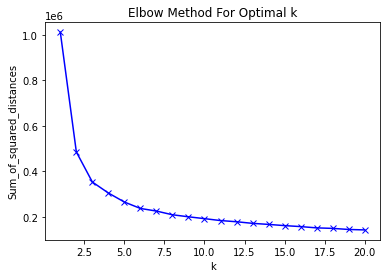

In [11]:
# Generate elbow-method diagram

#define function to find the best k number        
def fitting(df):
    Sum_of_squared_distances = []
    K = range(1,21)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

fitting(df_final)

In [12]:
# From the above figure, the optimal number of clusters is about k=3.

In [13]:
kmeans3 = KMeans(n_clusters=3, random_state=666, max_iter=1000,init='k-means++').fit(df_final)
print(kmeans3.cluster_centers_)

[[1.20189985e+00 1.47105834e+00 2.69158493e-01 3.63593185e-01
  7.70263294e-02 2.62756840e-01 7.76045431e-02 5.78626742e-02
  7.04181724e-02 2.60877646e-01 5.68714507e-02 7.60144553e-02
  6.05678885e-02 2.84047496e-01 7.15952504e-01 3.05833764e-02
  1.04099122e-01 6.24883841e-01 2.40433660e-01]
 [3.88585711e+00 4.05992104e+00 1.74063933e-01 3.32940652e+00
  3.03744269e-02 6.97274580e-02 3.04381049e-02 2.45765410e-01
  2.97058074e-02 6.92817117e-02 2.41785532e-01 3.94803872e-02
  2.43441161e-01 2.83653846e-01 7.16346154e-01 5.54954152e-02
  8.29470199e-01 1.13442435e-01 1.59195110e-03]
 [2.77532603e-01 2.88178708e+00 2.60425448e+00 9.77835077e-02
  1.98244657e-01 4.24951654e-02 1.97203352e-01 4.05117271e-02
  1.96558735e-01 3.95695939e-02 4.40819160e-02 2.00376853e-01
  4.09580007e-02 2.90722467e-01 7.09277533e-01 8.22631031e-02
  2.07269301e-02 2.20657510e-02 8.74944216e-01]]


In [14]:
# Also try 4 and 7 clusters.
# By looking at the results, customers are still divided into 3 main groups based on 
# location and the time range they purchase food, and then they have different purchasing
# amount(some people buy more and some buy less). Therefore we believe without further
# feature engineering, there's no need for more clusters, 3 is good enough.

In [15]:
kmeans4 = KMeans(n_clusters=4, random_state=666, max_iter=1000,init='k-means++').fit(df_final)
print(kmeans4.cluster_centers_)

[[3.95041742e+00 4.10381125e+00 1.53393829e-01 3.63633394e+00
  3.09981851e-02 4.76588022e-02 3.06715064e-02 2.59745917e-01
  3.01633394e-02 4.66424682e-02 2.56842105e-01 3.91651543e-02
  2.58112523e-01 2.82359347e-01 7.17640653e-01 6.11252269e-02
  8.86206897e-01 5.19419238e-02 7.25952813e-04]
 [7.19525007e-01 1.10480405e+00 3.85279042e-01 1.94422336e-01
  9.79593136e-02 2.34949540e-01 9.86915412e-02 4.78176435e-02
  9.26745408e-02 2.32721021e-01 4.83906912e-02 9.63038426e-02
  5.04918659e-02 2.83531247e-01 7.16468753e-01 3.64521983e-02
  6.52319251e-02 5.49902900e-01 3.48412976e-01]
 [2.33890112e+00 2.44472097e+00 1.05819853e-01 7.61366900e-01
  3.61347755e-02 2.97932421e-01 3.69005456e-02 8.92600747e-02
  2.89078204e-02 2.97549536e-01 8.39475447e-02 3.92457165e-02
  9.01215660e-02 2.86589452e-01 7.13410548e-01 1.92878338e-02
  2.21546856e-01 7.23987748e-01 3.51775629e-02]
 [2.75105485e-01 2.88031770e+00 2.60521221e+00 9.69471333e-02
  1.98361876e-01 4.23430132e-02 1.97319434e-01 4.0

In [16]:
kmeans6 = KMeans(n_clusters=6, random_state=666, max_iter=1000,init='k-means++').fit(df_final)
print(kmeans6.cluster_centers_)

[[4.27595570e+00 4.35975934e+00 8.38036418e-02 4.05830050e+00
  3.17857523e-02 3.47140880e-02 2.86976893e-02 2.72015760e-01
  2.97625386e-02 3.25843893e-02 2.63816420e-01 3.91864551e-02
  2.67436908e-01 2.83729102e-01 7.16270898e-01 6.14950485e-02
  9.26791609e-01 1.15536152e-02 1.59727399e-04]
 [3.05946091e-01 1.78431987e+00 1.47837378e+00 1.09563894e-01
  1.98531387e-01 3.98495567e-02 1.97277693e-01 4.39688368e-02
  1.95262828e-01 3.88197367e-02 4.59389272e-02 1.95665801e-01
  4.46852333e-02 2.87364556e-01 7.12635444e-01 8.05050596e-02
  3.49691054e-02 2.06859497e-02 8.63839885e-01]
 [1.36114236e+00 1.39079490e+00 2.96525434e-02 2.95650544e-01
  3.99950006e-02 3.61361080e-01 4.02137233e-02 4.34320710e-02
  3.02774653e-02 3.56580427e-01 4.32445944e-02 3.93388326e-02
  4.55568054e-02 2.83995751e-01 7.16004249e-01 9.24884389e-03
  5.55555556e-02 8.86920385e-01 4.82752156e-02]
 [2.68961172e+00 3.01244388e+00 3.22832165e-01 2.53469323e+00
  2.91407419e-02 3.34724738e-02 3.63077892e-02 2.6